# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

You are using pip version 9.0.1, however version 10.0.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


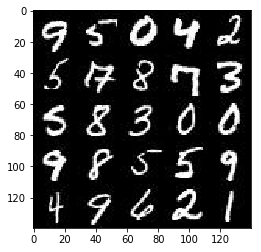

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
!pip install matplotlib==2.0.1
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

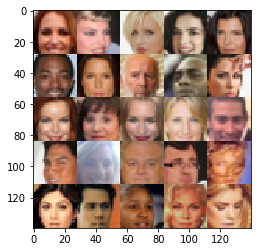

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real=tf.placeholder(dtype=tf.float32,shape=(None,image_width, image_height, image_channels))
    input_z=tf.placeholder(dtype=tf.float32,shape=(None,z_dim))
    learning_rate=tf.placeholder(dtype=tf.float32)
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/opt/co

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator',reuse=reuse):
        alpha = 0.2
        #images 28*28*3
        x1 = tf.layers.conv2d(images, 64, 5, 2, 'same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1=  tf.layers.dropout(x1,rate=0.1)
        x1 = tf. maximum(alpha*x1, x1)
        
        # 14*14*64
        x2 = tf.layers.conv2d(x1, 128, 5, 2, 'same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2=  tf.layers.dropout(x2,rate=0.1)
        x2 = tf.maximum(alpha*x2, x2)
        #7*7*128
        x3 = tf.layers.conv2d(x2, 256, 5, 2, 'same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3=  tf.layers.dropout(x3,rate=0.1)
        x3 = tf.maximum(alpha*x3, x3)
        
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.tanh(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator',reuse= not is_train):
        alpha = 0.2
        #First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        #reshape 
        x1 = tf.reshape(x1, (-1,4,4,512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1=  tf.layers.dropout(x1,rate=0.1)
        x1 = tf. maximum(alpha*x1, x1)

        # 8*7*256
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2=  tf.layers.dropout(x2,rate=0.1)
        x2 = tf.maximum(alpha*x2, x2)
       
        #14*14*128
        x3 = tf.layers.conv2d_transpose(x2, 128, 5,strides= 2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3=  tf.layers.dropout(x3,rate=0.1)
        x3 = tf.maximum(alpha*x3, x3)
        
        
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5,strides=2,padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        logits=tf.image.resize_images(logits, (28, 28))
      
        out = tf.multiply(tf.tanh(logits), 0.5)
    return out 


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth=0.1
    g_model=generator(input_z, out_channel_dim, is_train=True)
    d_model_real,d_logits_real=discriminator(input_real, reuse=False)
    d_model_fake,d_logits_fake=discriminator(g_model, reuse=True)
    
    d_loss_real=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,labels=tf.ones_like(d_model_real* (1 - smooth))))
    d_loss_fake=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.zeros_like(d_model_fake)))
    g_loss=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.ones_like(d_model_fake)))
    
    d_loss=d_loss_real+d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(np.asarray(images_grid), cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
import pickle as pkl
def train(epoch_count, batch_size, z_dim, learn_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    if data_image_mode == 'L' :
        channels = 1
    else :
        channels = 3
    input_real,input_z,learning_rate=model_inputs(28,28, channels, z_dim)
    d_loss,g_loss=model_loss(input_real, input_z, channels)
    d_opt,g_opt=model_opt(d_loss, g_loss, learning_rate, beta1)
    
    sample_z = np.random.uniform(-1, 1, size=(72,z_dim))
    samples, losses = [], []
    steps = 0
    
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
               
                
                _ = sess.run(d_opt, feed_dict={input_real:batch_images,input_z:batch_z, learning_rate:learn_rate})
                _ = sess.run(g_opt, feed_dict={input_z:batch_z,input_real:batch_images, learning_rate:learn_rate})
                
                if steps % 100 == 0 :
                    show_generator_output(sess, 16, input_z, channels, data_image_mode)
                    train_loss_d = d_loss.eval({input_z : batch_z, input_real:batch_images})
                    train_loss_g = g_loss.eval({input_z : batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                   # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
               
        

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
   
    return losses, samples
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

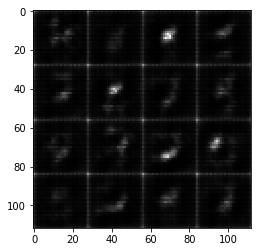

Epoch 1/2... Discriminator Loss: 1.1729... Generator Loss: 1.4572


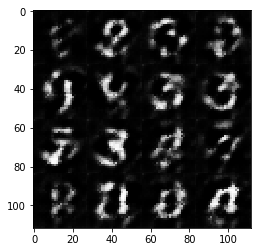

Epoch 1/2... Discriminator Loss: 1.3049... Generator Loss: 1.1188


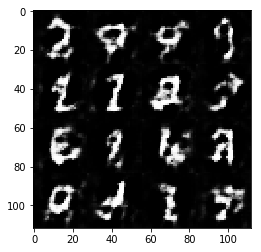

Epoch 1/2... Discriminator Loss: 1.1435... Generator Loss: 1.3744


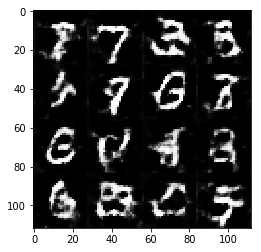

Epoch 1/2... Discriminator Loss: 1.3337... Generator Loss: 1.7916


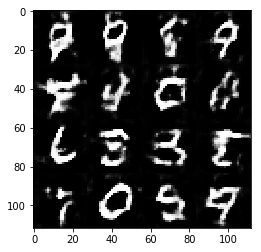

Epoch 1/2... Discriminator Loss: 1.1273... Generator Loss: 1.0103


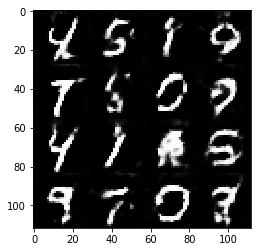

Epoch 1/2... Discriminator Loss: 1.0243... Generator Loss: 1.1891


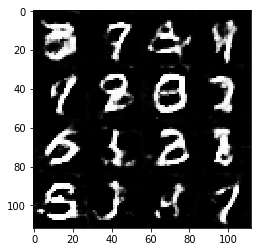

Epoch 1/2... Discriminator Loss: 1.0168... Generator Loss: 0.9725


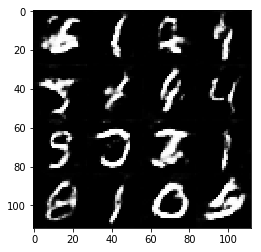

Epoch 1/2... Discriminator Loss: 1.0540... Generator Loss: 1.0207


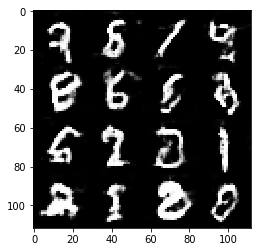

Epoch 1/2... Discriminator Loss: 0.9912... Generator Loss: 0.7809


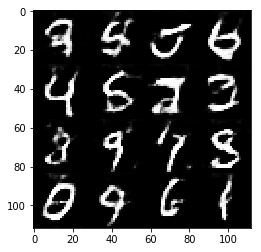

Epoch 1/2... Discriminator Loss: 1.3316... Generator Loss: 0.4496


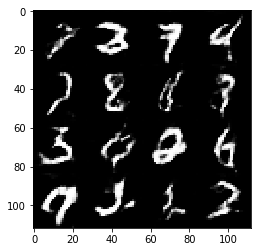

Epoch 1/2... Discriminator Loss: 1.0574... Generator Loss: 0.6247


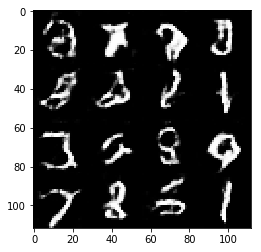

Epoch 1/2... Discriminator Loss: 1.1762... Generator Loss: 0.5907


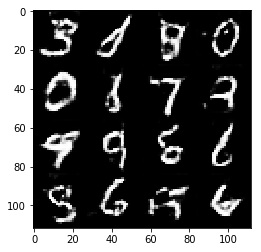

Epoch 1/2... Discriminator Loss: 2.8743... Generator Loss: 0.0709


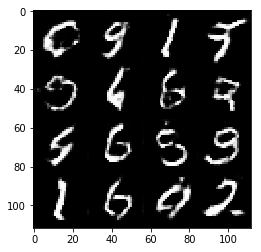

Epoch 1/2... Discriminator Loss: 1.1480... Generator Loss: 0.5265


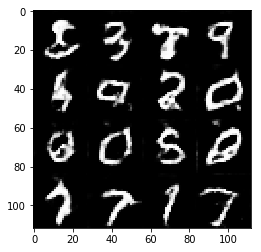

Epoch 1/2... Discriminator Loss: 2.0522... Generator Loss: 0.1849


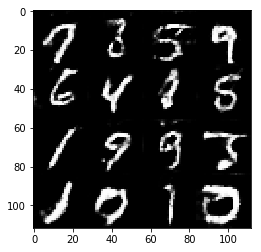

Epoch 1/2... Discriminator Loss: 1.5703... Generator Loss: 0.3474


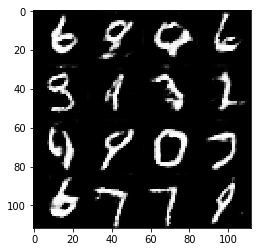

Epoch 1/2... Discriminator Loss: 0.9607... Generator Loss: 0.7039


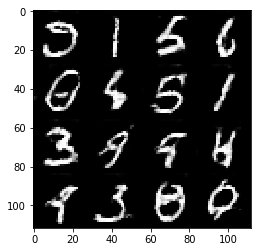

Epoch 1/2... Discriminator Loss: 0.3798... Generator Loss: 1.5589


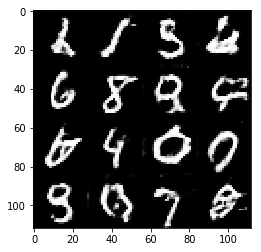

Epoch 1/2... Discriminator Loss: 1.2278... Generator Loss: 0.5084


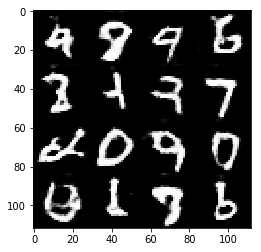

Epoch 1/2... Discriminator Loss: 4.3199... Generator Loss: 7.4197


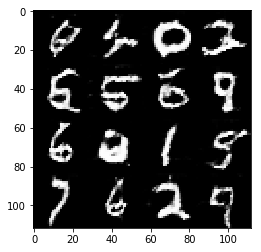

Epoch 2/2... Discriminator Loss: 0.3058... Generator Loss: 3.0071


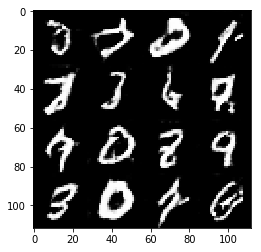

Epoch 2/2... Discriminator Loss: 0.4149... Generator Loss: 1.5330


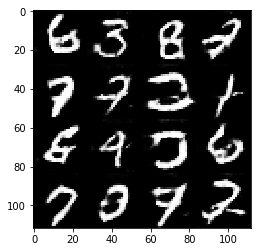

Epoch 2/2... Discriminator Loss: 0.8484... Generator Loss: 0.7845


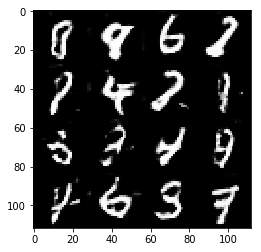

Epoch 2/2... Discriminator Loss: 1.0220... Generator Loss: 0.6239


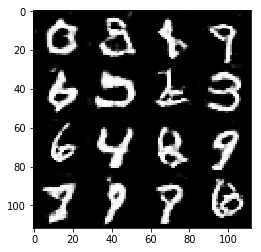

Epoch 2/2... Discriminator Loss: 1.8837... Generator Loss: 0.2285


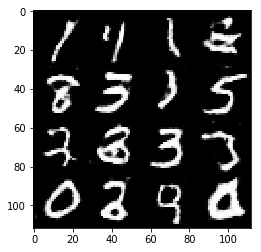

Epoch 2/2... Discriminator Loss: 0.5753... Generator Loss: 1.3335


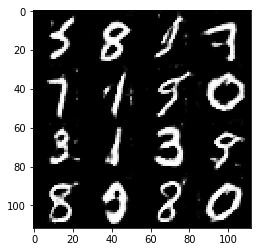

Epoch 2/2... Discriminator Loss: 1.4037... Generator Loss: 0.5164


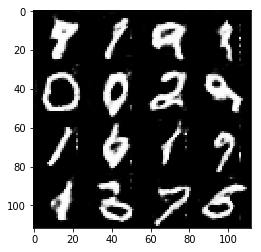

Epoch 2/2... Discriminator Loss: 1.9608... Generator Loss: 0.2493


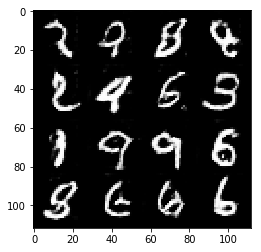

Epoch 2/2... Discriminator Loss: 0.6153... Generator Loss: 1.2233


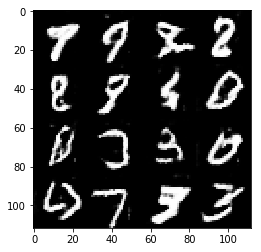

Epoch 2/2... Discriminator Loss: 0.5386... Generator Loss: 2.4702


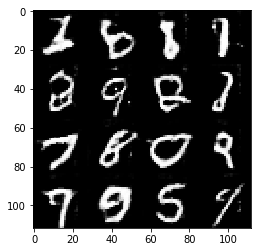

Epoch 2/2... Discriminator Loss: 1.3540... Generator Loss: 0.4458


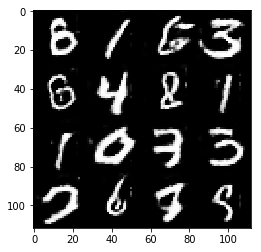

Epoch 2/2... Discriminator Loss: 1.2951... Generator Loss: 0.4775


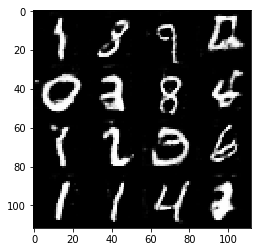

Epoch 2/2... Discriminator Loss: 1.1825... Generator Loss: 0.6568


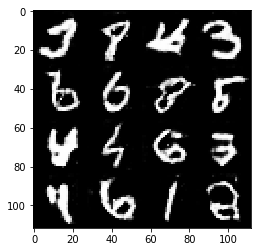

Epoch 2/2... Discriminator Loss: 0.6638... Generator Loss: 1.0844


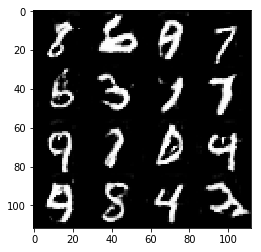

Epoch 2/2... Discriminator Loss: 0.6771... Generator Loss: 1.0463


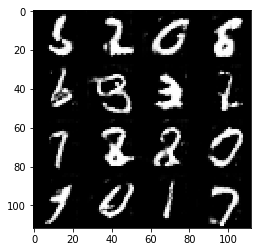

Epoch 2/2... Discriminator Loss: 0.6715... Generator Loss: 1.0784


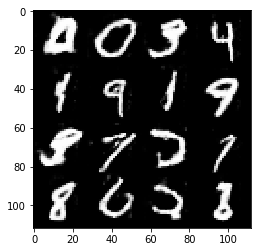

Epoch 2/2... Discriminator Loss: 1.6899... Generator Loss: 0.3247


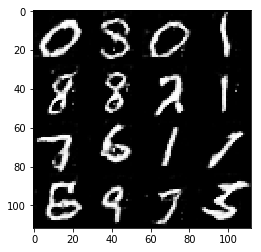

Epoch 2/2... Discriminator Loss: 0.6440... Generator Loss: 1.0360


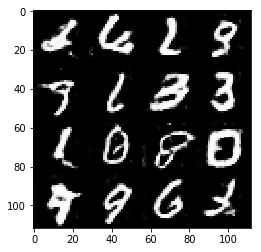

Epoch 2/2... Discriminator Loss: 0.7585... Generator Loss: 3.2330


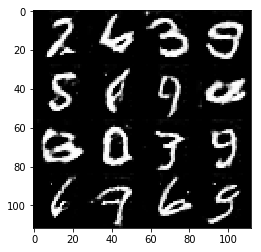

Epoch 2/2... Discriminator Loss: 0.2313... Generator Loss: 1.9823


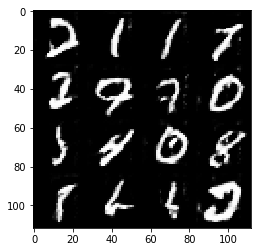

Epoch 2/2... Discriminator Loss: 0.3087... Generator Loss: 1.7523


In [12]:
batch_size = 29
z_dim = 100
learning_rate = .0006
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

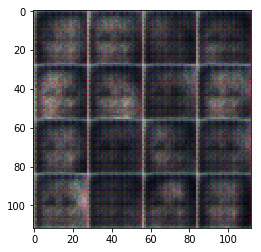

Epoch 1/1... Discriminator Loss: 1.7932... Generator Loss: 0.6841


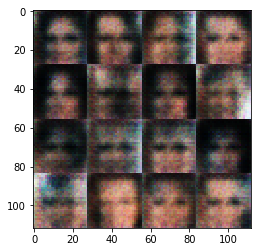

Epoch 1/1... Discriminator Loss: 1.6697... Generator Loss: 0.4028


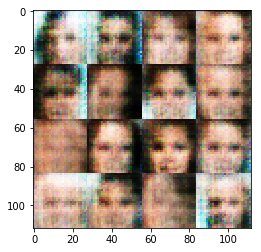

Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.5172


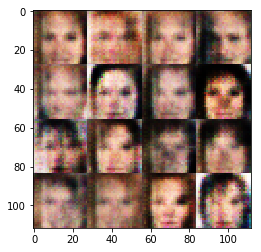

Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.7858


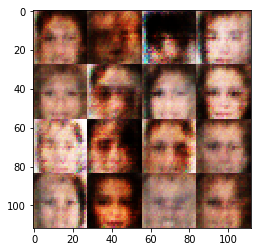

Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.7077


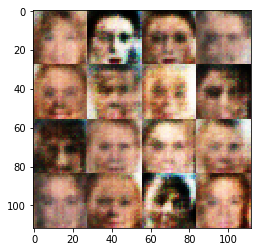

Epoch 1/1... Discriminator Loss: 1.5375... Generator Loss: 0.4304


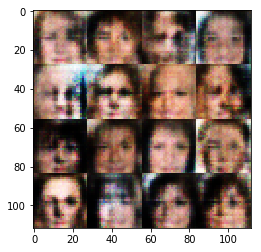

Epoch 1/1... Discriminator Loss: 1.4509... Generator Loss: 0.5517


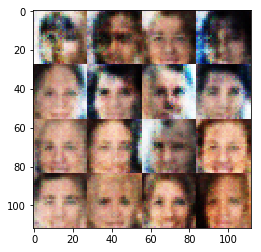

Epoch 1/1... Discriminator Loss: 1.3117... Generator Loss: 0.6337


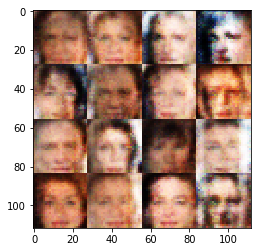

Epoch 1/1... Discriminator Loss: 1.4201... Generator Loss: 0.6053


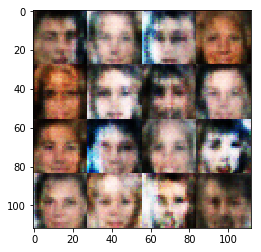

Epoch 1/1... Discriminator Loss: 1.3248... Generator Loss: 0.7249


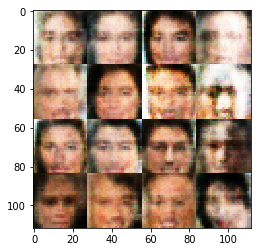

Epoch 1/1... Discriminator Loss: 1.3536... Generator Loss: 0.7638


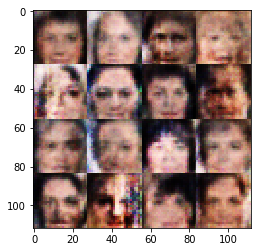

Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.6772


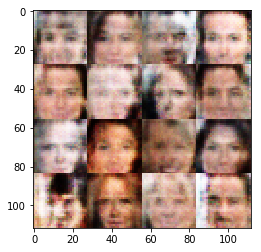

Epoch 1/1... Discriminator Loss: 1.3096... Generator Loss: 0.6782


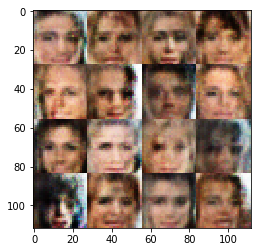

Epoch 1/1... Discriminator Loss: 1.5907... Generator Loss: 0.7472


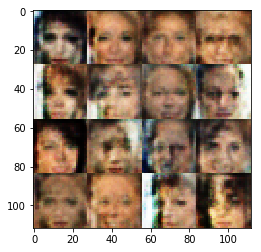

Epoch 1/1... Discriminator Loss: 1.5082... Generator Loss: 0.4236


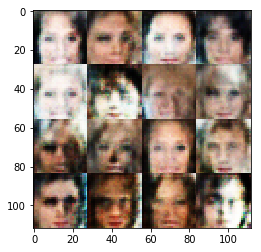

Epoch 1/1... Discriminator Loss: 1.4134... Generator Loss: 0.5966


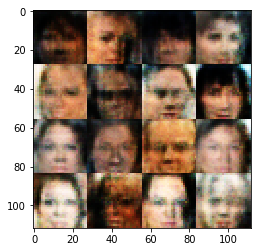

Epoch 1/1... Discriminator Loss: 1.2974... Generator Loss: 0.7911


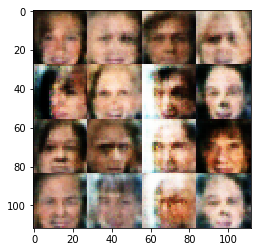

Epoch 1/1... Discriminator Loss: 1.2682... Generator Loss: 0.7848


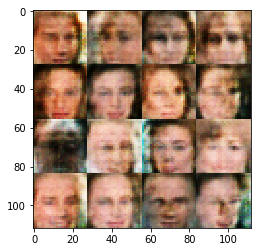

Epoch 1/1... Discriminator Loss: 1.2860... Generator Loss: 0.6455


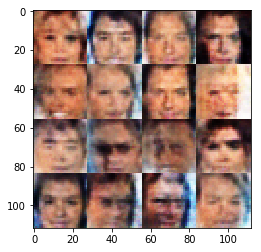

Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.6611


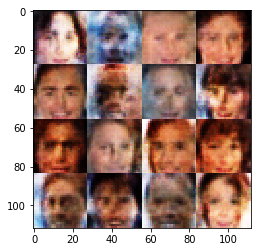

Epoch 1/1... Discriminator Loss: 1.4555... Generator Loss: 0.5468


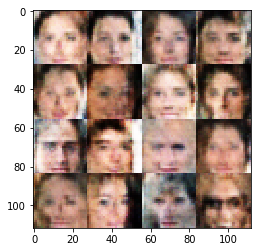

Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 0.7125


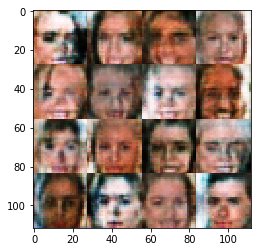

Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.7966


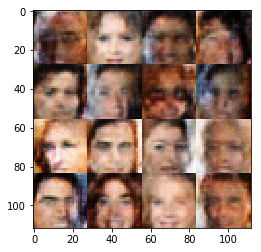

Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 0.7689


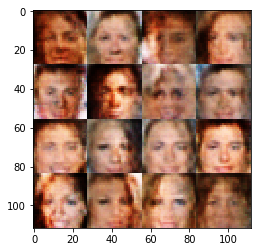

Epoch 1/1... Discriminator Loss: 1.3060... Generator Loss: 0.6811


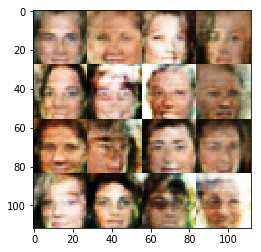

Epoch 1/1... Discriminator Loss: 1.3093... Generator Loss: 0.6526


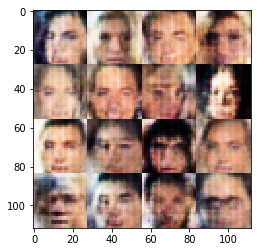

Epoch 1/1... Discriminator Loss: 1.2314... Generator Loss: 0.8428


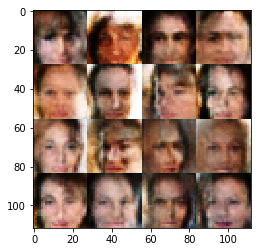

Epoch 1/1... Discriminator Loss: 1.3189... Generator Loss: 0.7456


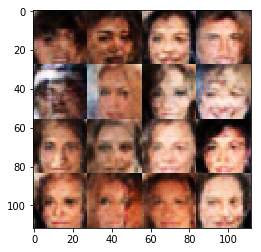

Epoch 1/1... Discriminator Loss: 1.3083... Generator Loss: 0.8559


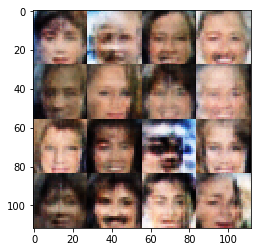

Epoch 1/1... Discriminator Loss: 1.4679... Generator Loss: 0.5594


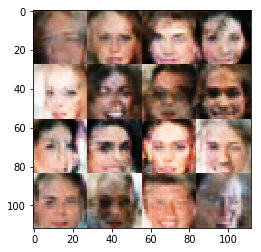

Epoch 1/1... Discriminator Loss: 1.4326... Generator Loss: 0.7950


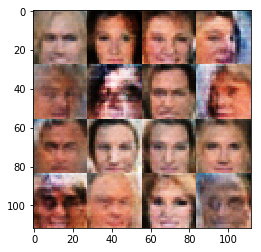

Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.7561


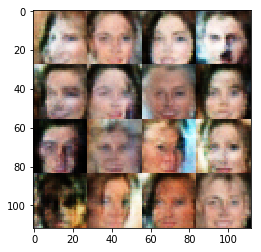

Epoch 1/1... Discriminator Loss: 1.2304... Generator Loss: 0.7678


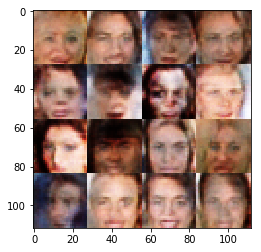

Epoch 1/1... Discriminator Loss: 1.2700... Generator Loss: 0.6163


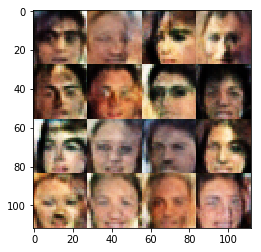

Epoch 1/1... Discriminator Loss: 1.3374... Generator Loss: 0.7810


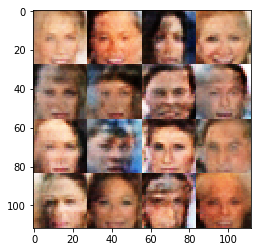

Epoch 1/1... Discriminator Loss: 1.4435... Generator Loss: 0.6777


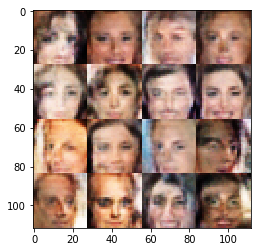

Epoch 1/1... Discriminator Loss: 1.2748... Generator Loss: 0.7370


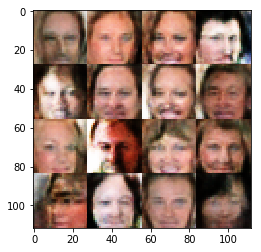

Epoch 1/1... Discriminator Loss: 1.3419... Generator Loss: 0.5442


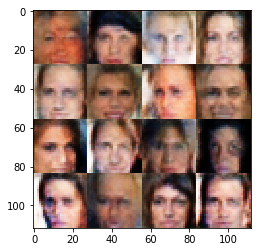

Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.5811


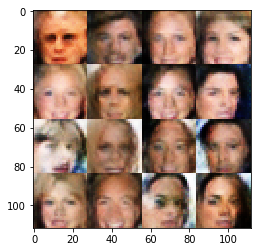

Epoch 1/1... Discriminator Loss: 1.5085... Generator Loss: 0.4594


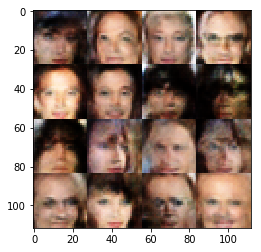

Epoch 1/1... Discriminator Loss: 1.2711... Generator Loss: 0.6744


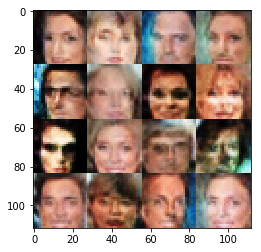

Epoch 1/1... Discriminator Loss: 1.2204... Generator Loss: 0.7192


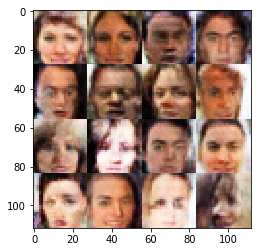

Epoch 1/1... Discriminator Loss: 1.0853... Generator Loss: 0.7251


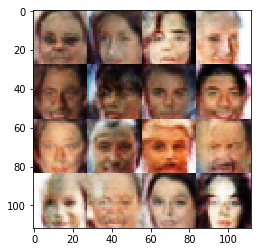

Epoch 1/1... Discriminator Loss: 1.3194... Generator Loss: 0.5925


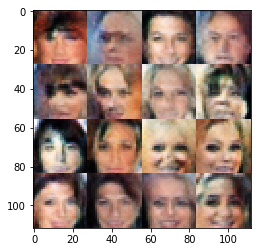

Epoch 1/1... Discriminator Loss: 1.2501... Generator Loss: 0.5720


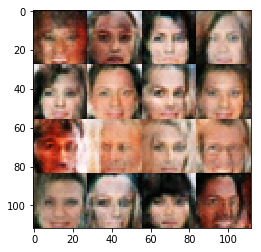

Epoch 1/1... Discriminator Loss: 1.5540... Generator Loss: 0.3502


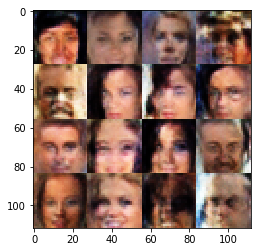

Epoch 1/1... Discriminator Loss: 1.3211... Generator Loss: 0.6991


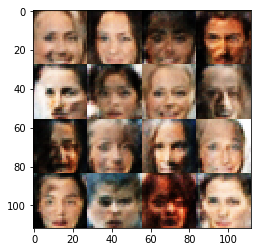

Epoch 1/1... Discriminator Loss: 1.3614... Generator Loss: 0.9687


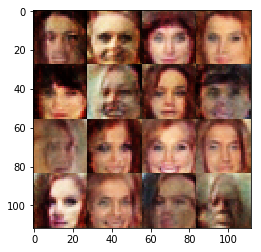

Epoch 1/1... Discriminator Loss: 1.4488... Generator Loss: 0.4629


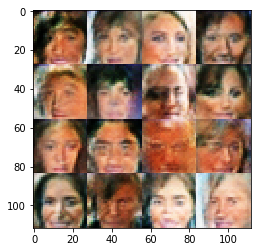

Epoch 1/1... Discriminator Loss: 1.0910... Generator Loss: 1.0317


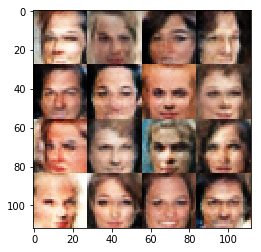

Epoch 1/1... Discriminator Loss: 1.5650... Generator Loss: 0.4420


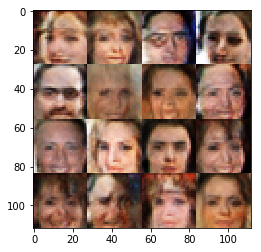

Epoch 1/1... Discriminator Loss: 1.3452... Generator Loss: 0.6165


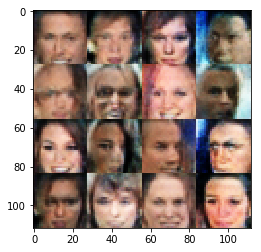

Epoch 1/1... Discriminator Loss: 1.2633... Generator Loss: 0.6372


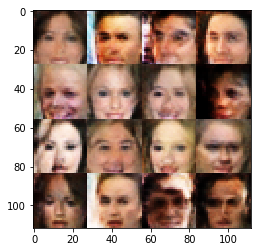

Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.5302


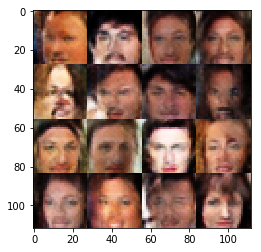

Epoch 1/1... Discriminator Loss: 1.2387... Generator Loss: 0.6515


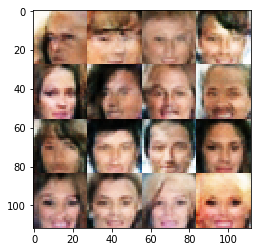

Epoch 1/1... Discriminator Loss: 1.2436... Generator Loss: 0.8104


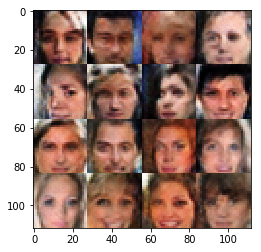

Epoch 1/1... Discriminator Loss: 1.4856... Generator Loss: 0.4866


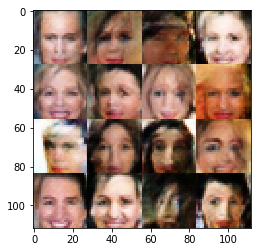

Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.4506


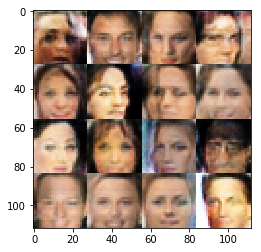

Epoch 1/1... Discriminator Loss: 1.4409... Generator Loss: 0.5142


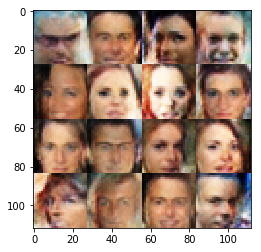

Epoch 1/1... Discriminator Loss: 1.4908... Generator Loss: 0.5771


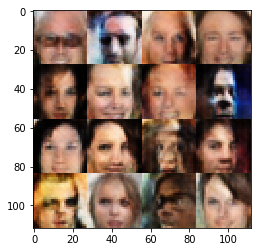

Epoch 1/1... Discriminator Loss: 1.5920... Generator Loss: 0.3564


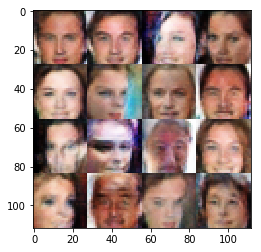

Epoch 1/1... Discriminator Loss: 1.2533... Generator Loss: 0.5807


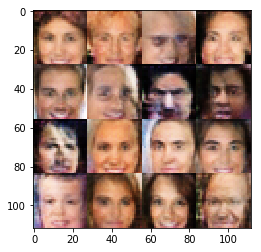

Epoch 1/1... Discriminator Loss: 1.2177... Generator Loss: 0.6182


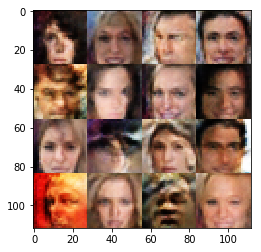

Epoch 1/1... Discriminator Loss: 1.3625... Generator Loss: 0.6449


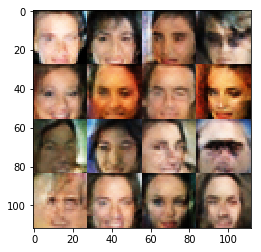

Epoch 1/1... Discriminator Loss: 1.1675... Generator Loss: 0.8976


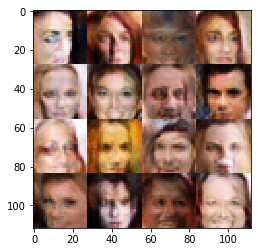

Epoch 1/1... Discriminator Loss: 1.2707... Generator Loss: 0.6197


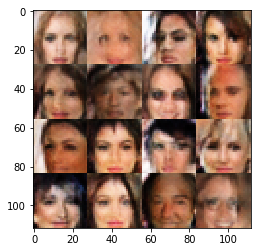

Epoch 1/1... Discriminator Loss: 1.2518... Generator Loss: 0.6837


In [13]:
batch_size = 30
z_dim = 100
learning_rate = 0.0004
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.